In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

## Importing the data

In [2]:
data = pd.read_csv("neonatal_basic_data.csv")
training_set = data[data['death']!=0]
training_labels = training_set['death']
training_data = training_set[['ga', 'bw']]
test_set = data[data['death']==0]
#test_labels = test_set['death']
test_data = test_set[['ga', 'bw']]

scale the data

In [3]:
scaler = StandardScaler()
training_data_stand = scaler.fit_transform(training_data)
test_data_stand = scaler.fit_transform(test_data)

minmaxscaler = MinMaxScaler()
training_data_minmax = minmaxscaler.fit_transform(training_data)
test_data_minmax = minmaxscaler.fit_transform(test_data)

## Visualization of the class distribution

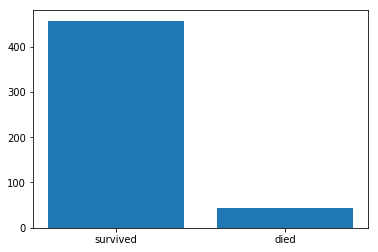

In [4]:
labels = training_labels.as_matrix()
classes, distribution = np.unique(labels, return_counts=True)
plt.bar(classes, distribution)
plt.xticks(classes, ["survived", "died"])
plt.show()

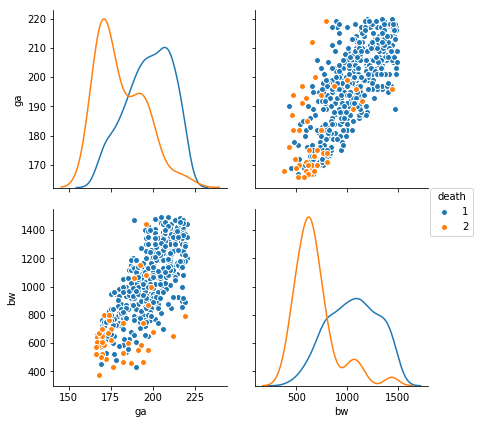

In [5]:
sns.pairplot(training_set[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

### Decision Trees

In [6]:
classifier = DecisionTreeClassifier()
classifier = classifier.fit(training_data_stand, training_labels)
print('score for decision trees: ', classifier.score(training_data_stand, training_labels))
print('f1 measure for decision trees: ', f1_score(training_labels, classifier.predict(training_data_stand),
                                                  average='weighted'))
p = classifier.predict(test_data_stand)

score for decision trees:  0.998
f1 measure for decision trees:  0.9979893281902925


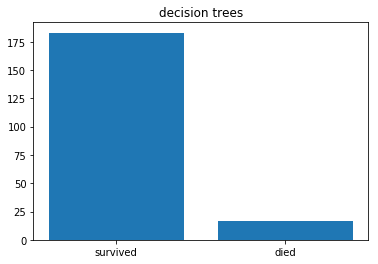

In [7]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('decision trees')
plt.xticks(classes, ["survived", "died"])
plt.show()

In [8]:
'''
sns.pairplot(training_set[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()
'''

'\nsns.pairplot(training_set[[\'ga\', \'bw\', \'death\']]\n             , hue="death"\n             , vars=[\'ga\', \'bw\']\n             , diag_kind="kde"\n             #, kind="reg"\n             , size=3\n            )\nplt.show()\n'

### SVM

In [9]:
SVM = svm.SVC(class_weight='balanced', kernel='rbf')
SVM.fit(training_data_stand, training_labels)
print('score for SVM: ', SVM.score(training_data_stand, training_labels))
print('f1 measure for SVM: ', f1_score(training_labels, SVM.predict(training_data_stand),
                                                  average='weighted'))
p = SVM.predict(test_data_stand)

score for SVM:  0.856
f1 measure for SVM:  0.8796950654978825


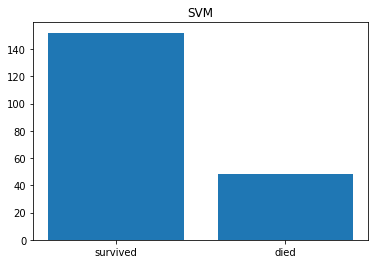

In [10]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('SVM')
plt.xticks(classes, ["survived", "died"])
plt.show()

### Logistic Regression

In [11]:
LogReg = LogisticRegression()
LogReg.fit(training_data_stand, training_labels)
print('score for logistic regression: ', LogReg.score(training_data_stand, training_labels))
print('f1 measure for logistic regression: ', f1_score(training_labels, LogReg.predict(training_data_stand),
                                                  average='weighted'))
p = LogReg.predict(test_data_stand)

score for logistic regression:  0.92
f1 measure for logistic regression:  0.8976493618354083


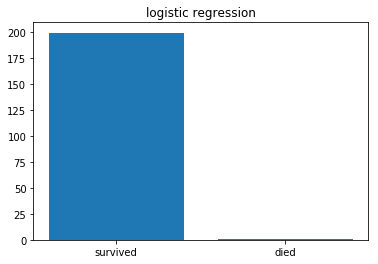

In [12]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('logistic regression')
plt.xticks(classes, ["survived", "died"])
plt.show()

### Naive Bayes

In [13]:
MNB = MultinomialNB()
MNB.fit(training_data_minmax, training_labels)
print('score for Multinomial Naive Bayes: ', MNB.score(training_data_minmax, training_labels))
print('f1 measure for Multinomial Naive Bayes: ', f1_score(training_labels, MNB.predict(training_data_minmax),
                                                  average='weighted'))
p = MNB.predict(test_data_minmax)

score for Multinomial Naive Bayes:  0.914
f1 measure for Multinomial Naive Bayes:  0.872932079414838


/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


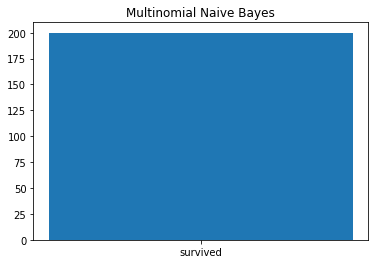

In [14]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Multinomial Naive Bayes')
plt.xticks(classes, ["survived", "died"])
plt.show()

In [15]:
GNB = GaussianNB()
GNB.fit(training_data_minmax, training_labels)
print('score for logistic regression: ', GNB.score(training_data_minmax, training_labels))
print('f1 measure for logistic regression: ', f1_score(training_labels, GNB.predict(training_data_minmax),
                                                  average='weighted'))
p = GNB.predict(test_data_minmax)

score for logistic regression:  0.892
f1 measure for logistic regression:  0.8995084501506617


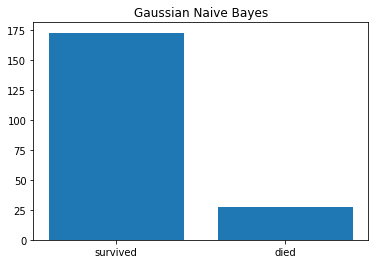

In [16]:
classes, distribution = np.unique(p, return_counts=True)
plt.bar(classes, distribution)
plt.title('Gaussian Naive Bayes')
plt.xticks(classes, ["survived", "died"])
plt.show()

### Gaussian Processes